# **Sales Analysis**

## Importing necessary libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
import matplotlib.ticker as mticker
from itertools import combinations
from collections import Counter

## Merging 12 months of Sales data into a single file

In [2]:
# Get list of CSV files (ensuring only CSVs are included)
csv_files_list = sorted([file for file in os.listdir("Sales_Data/") if file.endswith('.csv')])

all_months_data = pd.DataFrame()  # Create an empty DataFrame

for i, file in enumerate(csv_files_list):
    file_path = f"Sales_Data/{file}"

    # Read the first file normally, then skip headers for the rest
    temp_df = pd.read_csv(file_path, dtype=str)  # Read as string to avoid dtype issues

    # 🚨 Remove duplicate header rows in case they were appended as data
    temp_df = temp_df[temp_df.iloc[:, 0] != 'Order ID']  # Keep only valid data

    all_months_data = pd.concat([all_months_data, temp_df], ignore_index=True)

# 🚨 Drop any completely empty rows (if any exist)
all_months_data = all_months_data.dropna(how="all")

# Save the cleaned data
all_months_data.to_csv('all_data_cleaned.csv', index=False)

print("✅ Successfully merged CSV files without duplicate headers!")

✅ Successfully merged CSV files without duplicate headers!


## Reading in updating DataFrame

In [3]:
df = pd.read_csv('all_data_cleaned.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Order ID          185950 non-null  int64  
 1   Product           185950 non-null  object 
 2   Quantity Ordered  185950 non-null  int64  
 3   Price Each        185950 non-null  float64
 4   Order Date        185950 non-null  object 
 5   Purchase Address  185950 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 8.5+ MB


In [5]:
# This data only had empty rows which were cleaned at the start.
df.isna().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

## Augmenting data with additional columns

### Adding month column

In [6]:
# Changing Order Date column to datetime64
#df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Order Date'] = df['Order Date'].apply(lambda x: parser.parse(x) if pd.notnull(x) else pd.NaT)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  int64         
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  int64         
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  185950 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 8.5+ MB


In [8]:
df['Month'] = df['Order Date'].dt.month_name()

### Adding City & State column

In [9]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",April
1,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",April
2,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",April
3,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",April
4,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",April


### Adding Hour and Minute Column

In [10]:
df['Hour'] = df['Order Date'].dt.hour
df['Minute'] = df['Order Date'].dt.minute

In [11]:
def get_city(address):
    return address.split(',')[1]
def get_state(address):
    return address.split(',')[-1].split()[0]
    

df['City'] = df['Purchase Address'].apply(lambda x : f"{get_city(x)} ({get_state(x)})")
df['City']

0                 Dallas (TX)
1                 Boston (MA)
2            Los Angeles (CA)
3            Los Angeles (CA)
4            Los Angeles (CA)
                 ...         
185945       Los Angeles (CA)
185946     San Francisco (CA)
185947     San Francisco (CA)
185948     San Francisco (CA)
185949     San Francisco (CA)
Name: City, Length: 185950, dtype: object

# Exploratory Data Analysis

## What was the best month for Sales? How much was earned that month?

In [12]:
df['Sales']= df['Quantity Ordered'] * df['Price Each']

In [13]:
ser = df.groupby(by='Month')['Sales'].sum().sort_values(ascending=False)
ser

Month
December     4613443.34
October      3736726.88
April        3390670.24
November     3199603.20
May          3152606.75
March        2807100.38
July         2647775.76
June         2577802.26
August       2244467.88
February     2202022.42
September    2097560.13
January      1822256.73
Name: Sales, dtype: float64

****************************
**Answer**
- December had the largest Sales.
- Total Sales = 4613443.34

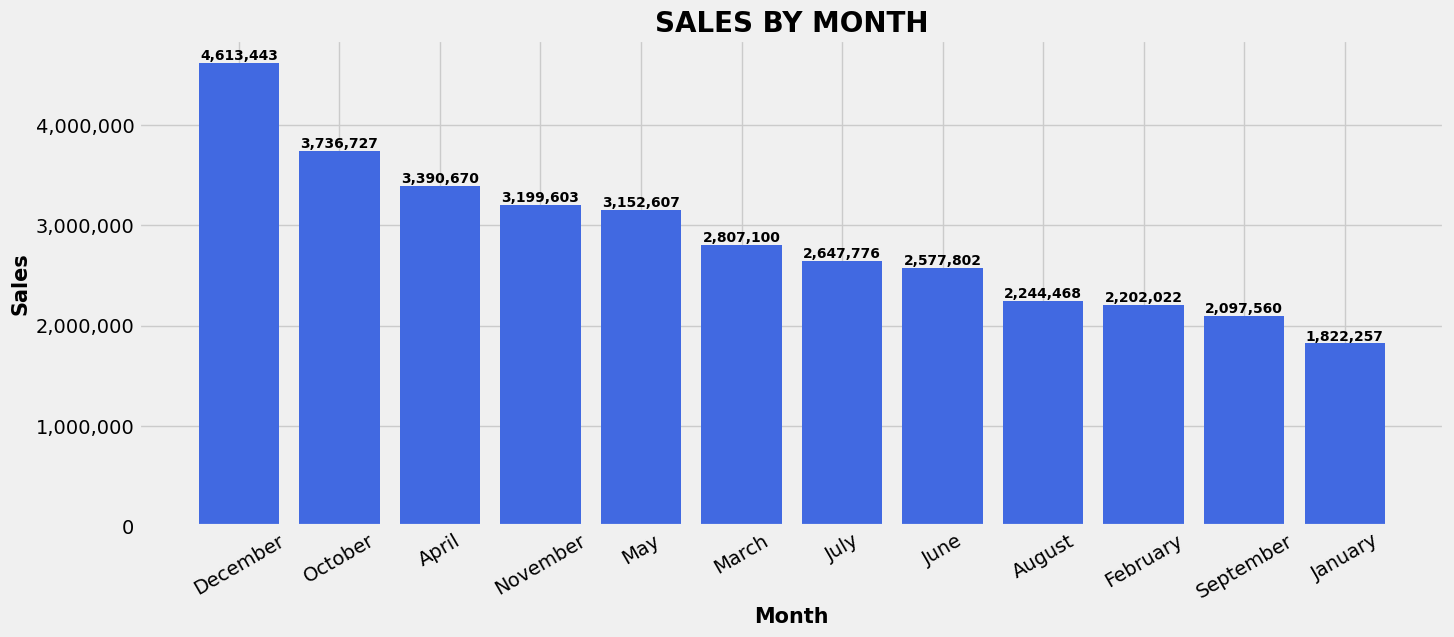

In [14]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,6))
bars = plt.bar(x = ser.index,height= ser.values, color='royalblue')

# Format Y-axis to show full numbers instead of scientific notation
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

for bar in bars:
    yval=bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', 
             ha='center', va='bottom', fontsize=10, fontweight='semibold')
plt.title('SALES BY MONTH',fontweight='bold',fontsize=20)
plt.xlabel('Month',fontsize=15, fontweight='semibold')
plt.ylabel('Sales',fontsize=15,fontweight='semibold')
plt.xticks(rotation=30)
plt.show()

**Key Observations**
- December has the highest sales (~4.6M) → Likely due to holiday shopping and year-end sales.
- October & April also show strong sales → Possible seasonal promotions or product launches.
- January has the lowest sales (~1.8M) → Post-holiday slowdown in consumer spending.
- Sales gradually increase towards the holiday season → Suggests an opportunity for targeted marketing in Q4.
- Mid-year sales (May–July) are relatively stable → Could indicate consistent demand across these months.

**Recommendations**
- Increase marketing & promotions in Q4 (October–December) to maximize revenue.
- Consider post-holiday offers in January to boost slow sales.
- Analyze sales drivers in April & October to replicate successful strategies.

## What city had highest number of Sales?

In [15]:
ser = df.groupby(by=['City'])['Sales'].sum().sort_values(ascending=False)
ser

City
San Francisco (CA)    8262203.91
Los Angeles (CA)      5452570.80
New York City (NY)    4664317.43
Boston (MA)           3661642.01
Atlanta (GA)          2795498.58
Dallas (TX)           2767975.40
Seattle (WA)          2747755.48
Portland (OR)         1870732.34
Austin (TX)           1819581.75
Portland (ME)          449758.27
Name: Sales, dtype: float64

****************************
**Answer**
- San Francisco, CA had the highest Sales.
- Total Sales = 8262203.91

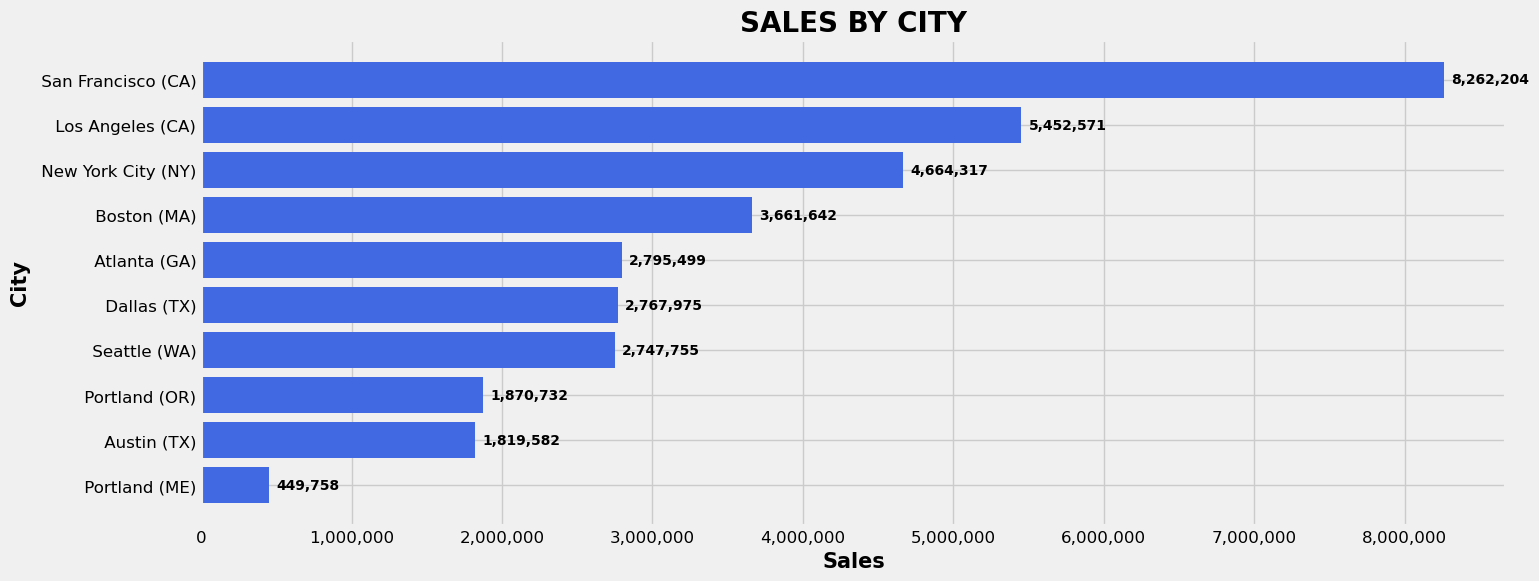

In [16]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,6))
bars = plt.barh(y = ser.index,width= ser.values, color='royalblue')

#Format Y-axis to show full numbers instead of scientific notation
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

for bar in bars:
    xval = bar.get_width()  # The sales value (length of the bar)
    plt.text(xval + 50000,  # 🔹 Offset the text slightly to the right
             bar.get_y() + bar.get_height()/2,  # 🔹 Center the text vertically
             f'{xval:,.0f}', 
             ha='left', va='center', fontsize=10, fontweight='semibold')

plt.gca().invert_yaxis()
plt.title('SALES BY CITY',fontweight='bold',fontsize=20)
plt.ylabel('City',fontsize=15, fontweight='semibold')
plt.xlabel('Sales',fontsize=15,fontweight='semibold')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

**Key Observations**
- San Francisco (CA) leads with the highest sales (~8.26M) → Strong customer base and high purchasing power.
- Los Angeles (CA) and New York City (NY) follow → Major metropolitan areas with high demand.
- Boston (MA) also performs well (~3.66M) → Possibly due to strong retail presence or tech influence.
- Portland (ME) has the lowest sales (~449K) → Smallest market among listed cities.
- Texas cities (Dallas, Austin) have moderate sales but lag behind other major cities.

**Recommendations**
- Prioritize marketing in top cities (San Francisco, LA, NYC) to maximize revenue.
- Analyze factors driving low sales in Portland (ME) to explore growth opportunities.
- Consider localized promotions in mid-tier cities (Boston, Atlanta, Dallas, Seattle).

## What time should we display advertisements to maximize the likelihood of customer’s buying product?

In [17]:
ser = df.groupby('Hour')['Quantity Ordered'].sum()

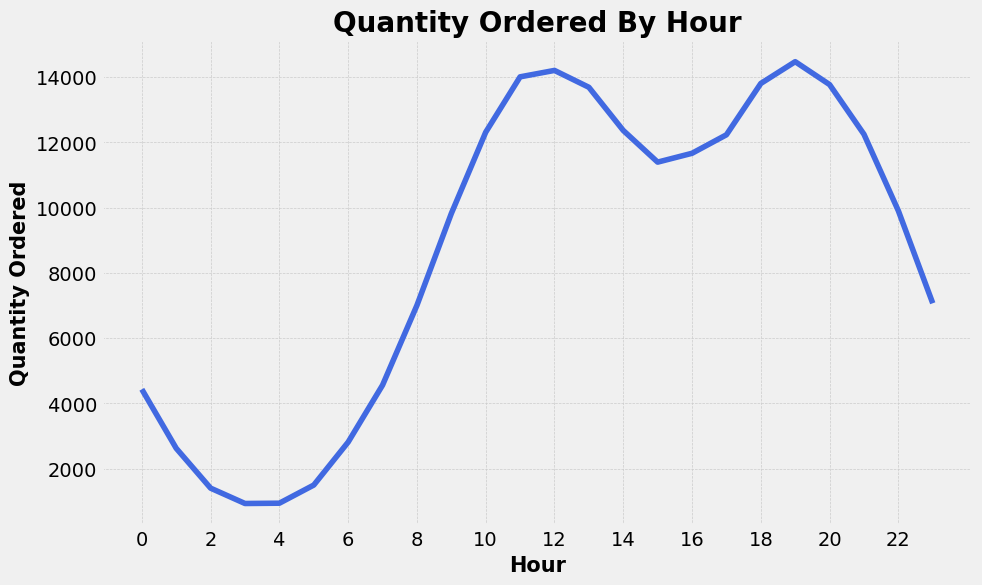

In [18]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
bars = plt.plot(ser, color='royalblue')

plt.title('Quantity Ordered By Hour',fontweight='bold',fontsize=20)
plt.ylabel('Quantity Ordered',fontsize=15, fontweight='semibold')
plt.xlabel('Hour',fontsize=15,fontweight='semibold')
plt.xticks(range(0,24,2))
plt.grid(visible=True, ls='--',lw=0.5)
plt.show()

📌 Insights from the "Quantity Ordered By Hour" Chart
The chart shows the total quantity of products ordered at different hours of the day. Here are the key insights:

**Peak Buying Hours (Best Time for Ads)**
- Most purchases occur around 11 AM - 12 PM and again at 6 PM - 8 PM.
- These time slots are ideal for displaying advertisements since customers are most active and likely to make purchases.
*Why? This could align with*:
- Lunch breaks (11 AM - 12 PM) when people have time to browse and shop.
- Evening relaxation time (6 PM - 8 PM) when customers unwind and shop online.

**Low Activity Hours (Not Ideal for Ads)**
- The lowest sales occur between 12 AM - 6 AM.
- Running ads during this period is not cost-effective, as very few customers are making purchases.

************************************************
**Actionable Recommendations**

*Optimize Ad Timing:*
- Schedule ads between 10 AM - 12 PM to capture customers just before peak purchasing hours.
- Run ads between 6 PM - 8 PM when another surge in sales occurs.
- Avoid spending on ads from 12 AM - 6 AM, as sales volume is very low.

*Leverage Discounts & Promotions:*
- Offer limited-time discounts between 10 AM - 12 PM and 6 PM - 8 PM to further boost conversions.
- Use flash sales or urgency-based offers during peak hours.

*Optimize Inventory Management:*
- Ensure sufficient stock is available during high-demand hours.
- Consider off-peak discounts (e.g., early morning deals) to encourage sales during slow periods.
  
*************************************************
**Final Summary**
- Best time for ads: 10 AM - 12 PM, 6 PM - 8 PM
- Avoid ad spending: 12 AM - 6 AM
- Leverage promotions & stock availability during peak hours

## What are the top 10 pairs of products that are most often sold together?

In [19]:
multiple_orders =df[df['Order ID'].duplicated(keep=False)].copy()
multiple_orders['Grouped'] = multiple_orders.groupby('Order ID')['Product'].transform(lambda x: ", ".join(x))
multiple_orders = multiple_orders[['Order ID','Grouped']].drop_duplicates()

In [20]:
count = Counter()
for row in multiple_orders['Grouped']:
    row_list = row.split(",")
    count.update(Counter(combinations(row_list,2)))
data = count.most_common(10)


ser = pd.Series(dict(data))
ser.index = pd.MultiIndex.from_tuples(ser.index, names=["Primary Product", "Secondary Product"])
ser

Primary Product        Secondary Product         
iPhone                 Lightning Charging Cable      1005
Google Phone           USB-C Charging Cable           987
iPhone                 Wired Headphones               447
Google Phone           Wired Headphones               414
Vareebadd Phone        USB-C Charging Cable           361
iPhone                 Apple Airpods Headphones       360
Google Phone           Bose SoundSport Headphones     220
Vareebadd Phone        Wired Headphones               143
 USB-C Charging Cable  Wired Headphones               120
Vareebadd Phone        Bose SoundSport Headphones      80
dtype: int64

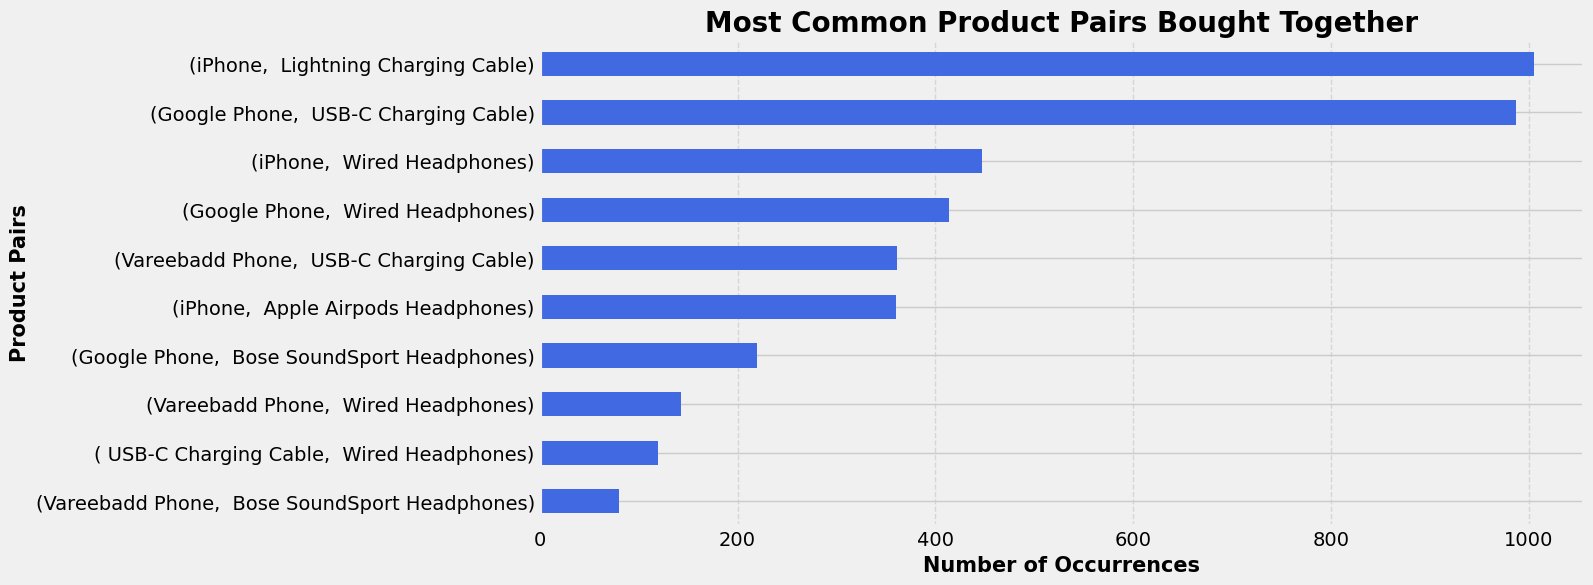

In [21]:
plt.figure(figsize=(12, 6))
ser.sort_values().plot(kind='barh', color='royalblue')

plt.title('Most Common Product Pairs Bought Together', fontsize=20, fontweight='bold')
plt.xlabel('Number of Occurrences', fontsize=15,fontweight='semibold')
plt.ylabel('Product Pairs', fontsize=15,fontweight='semibold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## What product sold the most? Why do you think it sold the most?

In [22]:
ser_products = df.groupby('Product')['Quantity Ordered'].sum().nlargest(5)

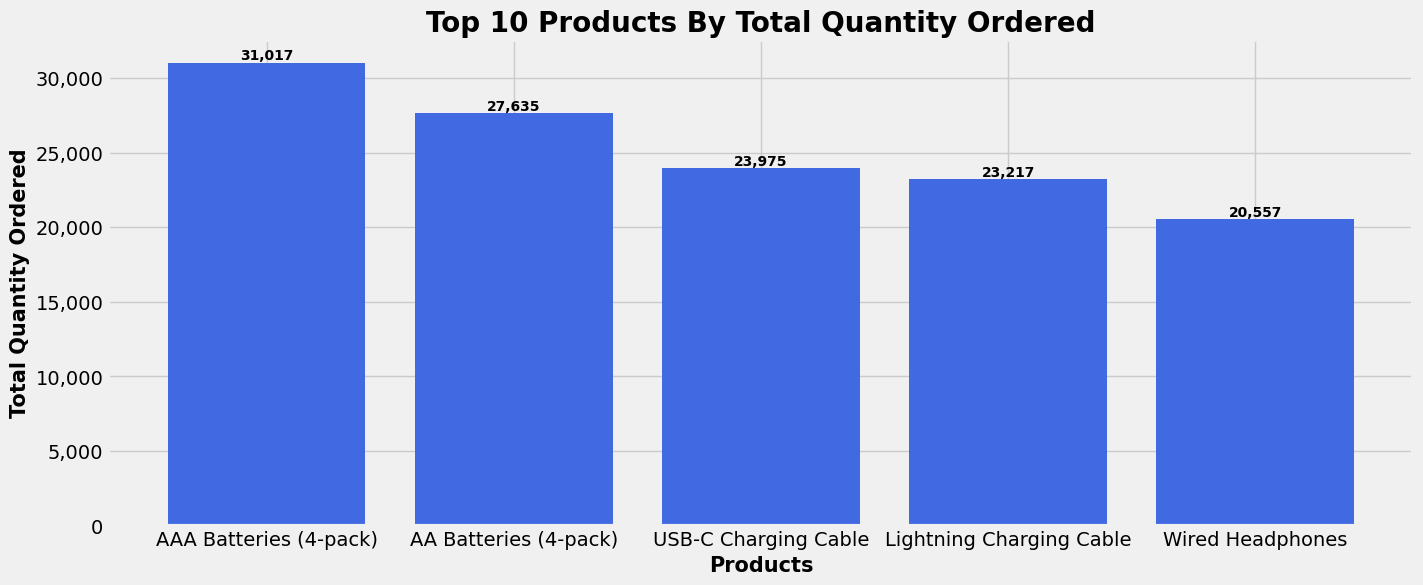

In [23]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,6))
bars = plt.bar(x = ser_products.index,height= ser_products.values, color='royalblue')

# Format Y-axis to show full numbers instead of scientific notation
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

for bar in bars:
    yval=bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', 
             ha='center', va='bottom', fontsize=10, fontweight='semibold')
plt.title('Top 10 Products By Total Quantity Ordered',fontweight='bold',fontsize=20)
plt.xlabel('Products',fontsize=15, fontweight='semibold')
plt.ylabel('Total Quantity Ordered',fontsize=15,fontweight='semibold')
plt.show()

- One of the reasons : These products were sold the most because of their cheap price.

In [24]:
ser_prices = df.groupby('Product')['Price Each'].mean().nsmallest(5)
ser_prices

Product
AAA Batteries (4-pack)       2.99
AA Batteries (4-pack)        3.84
USB-C Charging Cable        11.95
Wired Headphones            11.99
Lightning Charging Cable    14.95
Name: Price Each, dtype: float64

- Clearly the top 5 products which were sold the most are also the top 5 products which are the cheapest.

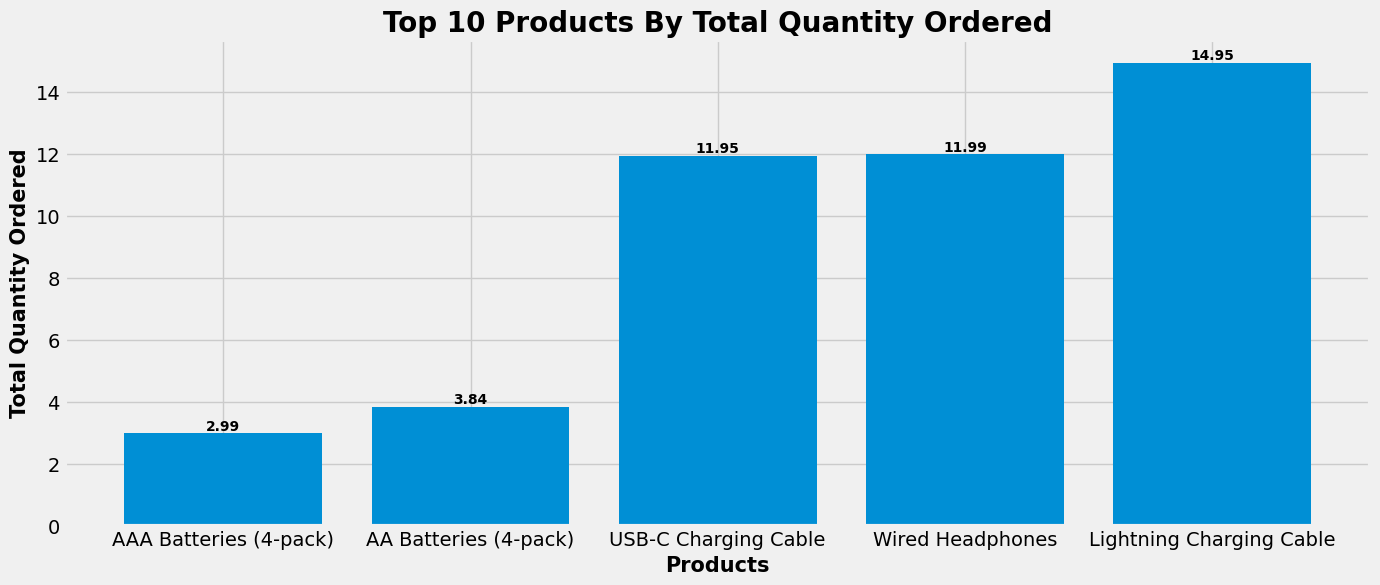

In [25]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,6))
bars = plt.bar(x = ser_prices.index,height= ser_prices.values)

# Format Y-axis to show full numbers instead of scientific notation
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

for bar in bars:
    yval=bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='semibold')
plt.title('Top 10 Products By Total Quantity Ordered',fontweight='bold',fontsize=20)
plt.xlabel('Products',fontsize=15, fontweight='semibold')
plt.ylabel('Total Quantity Ordered',fontsize=15,fontweight='semibold')
plt.show()